<a href="https://colab.research.google.com/github/amadousysada/ecommerce-customer-segmentation/blob/main/p5_notebook_3_maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.manifold import TSNE
from scipy.stats import ks_2samp
import numpy as np
import seaborn as sns

In [ ]:
t_init = time.time()

In [ ]:
folder_path = "/content/drive/MyDrive/data/" # A ajuster selon le chemin où se trouve votre fichier .db

# 0 | Préparation des données

In [ ]:
data = pd.read_csv(folder_path + "olist_orders_cleaned_data.csv")

In [ ]:
data.head()

,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_day,nbre_items,total_price,distinct_products,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,total_reviews,mean_score_review,payment_installments
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-02 11:07:15.000000000,2017-10-04 19:55:00,2017-10-10 21:25:13.000000000,2017-10-18,Mardi,1,38.71,1,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,4.0,1
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07-26 03:24:27.000000000,2018-07-26 14:31:00,2018-08-07 15:27:45.000000000,2018-08-13,Mardi,1,141.46,1,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,4.0,1
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-08 08:55:23.000000000,2018-08-08 13:50:00,2018-08-17 18:06:29.000000000,2018-09-04,Vendredi,1,179.12,1,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,5.0,3
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11-18 19:45:59.000000000,2017-11-22 13:39:59,2017-12-02 00:28:42.000000000,2017-12-15,Samedi,1,72.20,1,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,5.0,1
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-13 22:20:29.000000000,2018-02-14 19:46:34,2018-02-16 18:17:02.000000000,2018-02-26,Vendredi,1,28.62,1,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,5.0,1


In [ ]:
data.describe()

,nbre_items,total_price,distinct_products,customer_zip_code_prefix,total_reviews,mean_score_review,payment_installments
count,96477.000000,96477.000000,96477.000000,96477.000000,96477.000000,96477.000000,96477.000000
mean,1.142179,159.827008,1.038538,35198.398862,0.998787,4.128390,2.928024
std,0.538773,218.795346,0.227943,29839.786348,0.110728,1.323427,2.712723
min,1.000000,9.590000,1.000000,1003.000000,0.000000,0.000000,0.000000
25%,1.000000,61.850000,1.000000,11355.000000,1.000000,4.000000,1.000000
50%,1.000000,105.280000,1.000000,24435.000000,1.000000,5.000000,2.000000
75%,1.000000,176.260000,1.000000,59056.000000,1.000000,5.000000,4.000000
max,21.000000,13664.080000,8.000000,99980.000000,3.000000,5.000000,24.000000


In [ ]:
rfm_feats = ['recency', 'monetary', 'frequency']

# 1 | Simulation de l'évolution de la stabilité du clustering

Pour suivre la stabilité du clustering dans le temps, nous allons :
- Découper nos données par périodes (par exemple, par mois ou par trimestre).  
- Recalculer le clustering pour chaque période avec les mêmes paramètres.
- Comparer les affectations des clusters de chaque période avec le clustering final via l’Adjusted Rand Index (ARI).
- Étudier l’évolution des distributions de nos features à l’aide d’un test de Kolmogorov-Smirnov (KS).


In [ ]:
data.order_purchase_timestamp = pd.to_datetime(data.order_purchase_timestamp)

In [ ]:
start_date = min(data.order_purchase_timestamp) # Correspond à la premiére commande dans l'ensemble de notre dataset
end_date = max(data.order_purchase_timestamp) # Correspond à la derniére commande dans l'ensemble de notre dataset
print("First order ever", start_date)
print("Last order", end_date)

First order ever 2016-10-03 09:44:50
Last order 2018-08-29 15:00:37


In [ ]:
# Calcul des periodes
periods = (end_date - start_date).days
print(f"L'ensemble de nos données s'étale sur {periods} jours, soit {periods / 365} années, soit en moyenne {periods / 30.4} mois.")

L'ensemble de nos données s'étale sur 695 jours, soit 1.904109589041096 années, soit en moyenne 22.861842105263158 mois.


In [ ]:
# Nous prenderons les 12 premiers mois comme données de reference pour construire le modéle Kmean de reference
ref_date = start_date + pd.DateOffset(months=12)
print(f"La date de reference correspond au {ref_date}")

La date de reference correspond au 2017-10-03 09:44:50


In [ ]:
# Liste des dates d'analyse : chaque premier du mois à partir du mois suivant la référence
months = pd.date_range(start=ref_date, end=end_date, freq='MS', )

print(f"Il y a {len(months)} mois à analyser:")
print("\n".join([str(m) for m in months]))

Il y a 10 mois à analyser:
2017-11-01 09:44:50
2017-12-01 09:44:50
2018-01-01 09:44:50
2018-02-01 09:44:50
2018-03-01 09:44:50
2018-04-01 09:44:50
2018-05-01 09:44:50
2018-06-01 09:44:50
2018-07-01 09:44:50
2018-08-01 09:44:50


In [ ]:
# Fonction pour filtrer par rapport à une date donnée
def compute_rfm(df, current_date):

  df_period = df[df.order_purchase_timestamp <= current_date].copy()

  # Recency
  last_date = df_period['order_purchase_timestamp'].max()
  df_period.loc[:, 'Recency'] = (last_date - df_period['order_purchase_timestamp']).dt.days

  # Frequency
  frequency = df_period.groupby('customer_unique_id')['order_id'].count().reset_index()
  frequency.columns = ['customer_unique_id', 'Frequency']
  df_period = df_period.merge(frequency, on='customer_unique_id')

  # Monetary Value
  monetary_value = df_period.groupby('customer_unique_id')['total_price'].sum().reset_index()
  monetary_value.columns = ['customer_unique_id', 'MonetaryValue']
  df_period = df_period.merge(monetary_value, on='customer_unique_id')


  rfm = df_period.groupby('customer_unique_id').agg(
    recency=('Recency', 'min'),
    frequency=('Frequency', 'max'),
    monetary=('MonetaryValue', 'sum')
  ).reset_index()

  # Transformation des donnéés
  rfm.frequency = np.log10(rfm.frequency)
  rfm.monetary = np.log1p(rfm.monetary)

  # Standardisation des données
  from sklearn.preprocessing import StandardScaler, RobustScaler
  ss = StandardScaler()
  rs = RobustScaler()
  rfm[['monetary', 'recency']] = ss.fit_transform(rfm[['monetary', 'recency']])
  rfm[['frequency']] = rs.fit_transform(rfm[['frequency']])

  return rfm

df_evolution = {}

# 3 | Calcul du modèle de référence

In [ ]:
rfm_ref = compute_rfm(data, ref_date)

n_clusters = 6

# Clustering sur le modèle de référence
kmeans_ref = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_ref.fit(rfm_ref[rfm_feats])
rfm_ref["cluster"] = kmeans_ref.labels_
df_evolution['PO'] = rfm_ref

In [ ]:
rfm_ref.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25946 entries, 0 to 25945
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  25946 non-null  object 
 1   recency             25946 non-null  float64
 2   frequency           25946 non-null  float64
 3   monetary            25946 non-null  float64
 4   cluster             25946 non-null  int32  
dtypes: float64(3), int32(1), object(1)
memory usage: 912.3+ KB


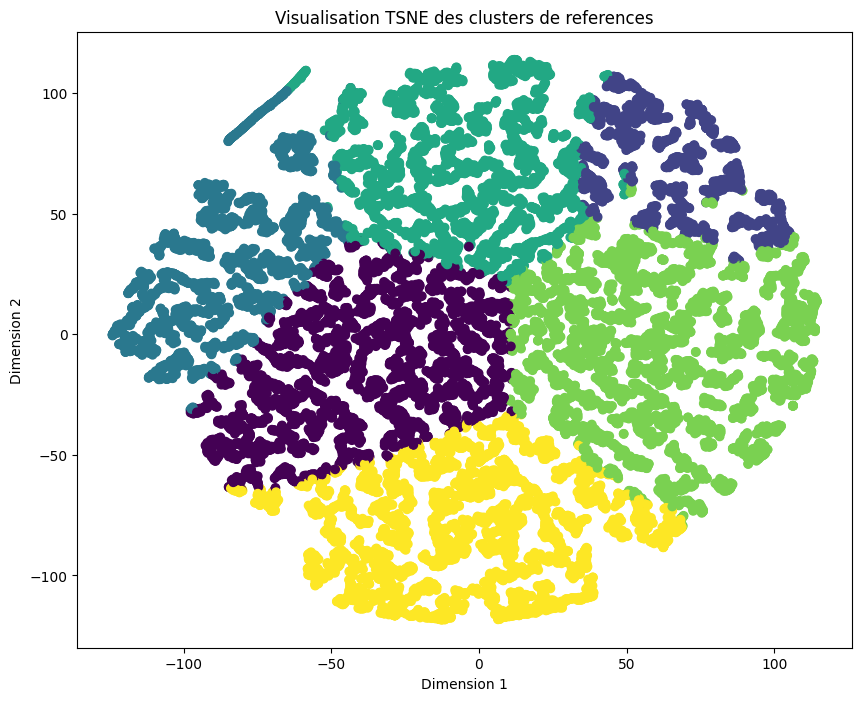

CPU times: user 5min 8s, sys: 431 ms, total: 5min 9s
Wall time: 5min 9s


In [ ]:
%%time
tsne = TSNE(n_components=2, random_state=42)
rfm_ref_tsne = tsne.fit_transform(rfm_ref[rfm_feats])

fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(rfm_ref_tsne[:, 0], rfm_ref_tsne[:, 1], c=rfm_ref["cluster"], cmap="viridis")
ax.set_title("Visualisation TSNE des clusters de references")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
plt.show()

# 4 | Suivi mensuel du clustering

Pour chaque mois postérieur à la date de référence, nous recalculons le clustering et comparons le résultat au modèle de référence via l’ARI.

Le score ARI (Adjusted Rand Index) mesure la similarité entre le clustering de référence et le clustering recalculé à chaque période. Un ARI proche de 1 indique des clusters presque identiques, alors qu’un ARI proche de 0 (voire négatif) indique des clusters très différents.

Nous fixerons un seuil de **ARI = 0.7**

In [ ]:
%%time
ari_scores = {}

for i, current_date in enumerate(months):
    rfm_current = compute_rfm(data, current_date)

    # Recalculer le clustering pour la période courante
    kmeans_current = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_current.fit(rfm_current[rfm_feats])

    # Ne garder que les clients présents dans le modèle de référence pour comparaison
    common_customers = rfm_ref[rfm_ref.customer_unique_id.isin(list(rfm_current.customer_unique_id))]

    if len(common_customers) == 0:
        print(f"Aucune donnée disponible pour la période {current_date.strftime('%Y-%m')}")
        ari_scores[current_date.strftime("%Y-%m")] = None
        df_evolution[f"P{str(i)}"] = None
        continue

    rfm_current["cluster"] = kmeans_current.labels_
    rfm_current = rfm_current[rfm_current.customer_unique_id.isin(list(common_customers.customer_unique_id))]

    # Calculer l'ARI entre le clustering de référence et celui de la période courante
    ari = adjusted_rand_score(rfm_ref.cluster, rfm_current["cluster"])
    ari_scores[current_date.strftime("%Y-%m")] = ari

    df_evolution[f"P{str(i)}"] = rfm_current

    print(f"ARI pour la période {current_date.strftime('%Y-%m')}: {ari}")

ARI pour la période 2017-11: 0.5344451474529265
ARI pour la période 2017-12: 0.4651740992114607
ARI pour la période 2018-01: 0.4285149122487621
ARI pour la période 2018-02: 0.34582925134248454
ARI pour la période 2018-03: 0.3649652241579343
ARI pour la période 2018-04: 0.3440291140047193
ARI pour la période 2018-05: 0.32311575425283134
ARI pour la période 2018-06: 0.3040483097929796
ARI pour la période 2018-07: 0.2836107296429589
ARI pour la période 2018-08: 0.27550789808817533
CPU times: user 8.5 s, sys: 65.8 ms, total: 8.57 s
Wall time: 7.76 s


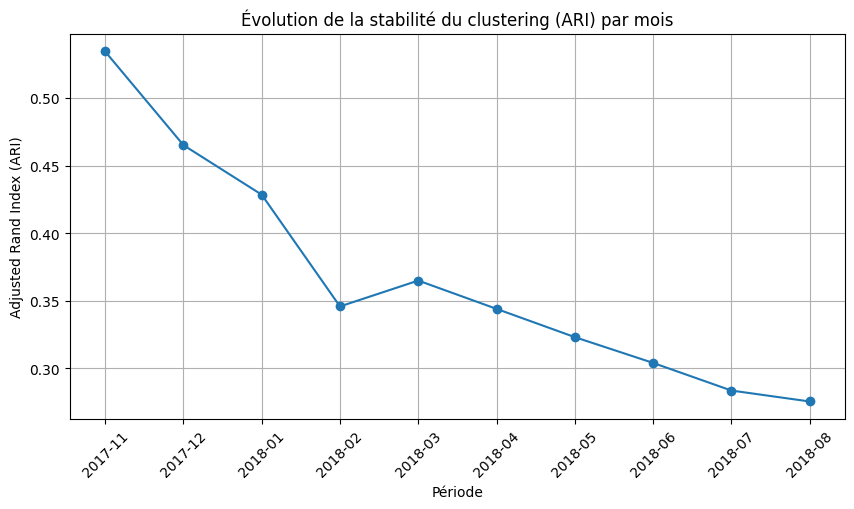

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(list(ari_scores.keys()), list(ari_scores.values()), marker="o", linestyle='-')
plt.title("Évolution de la stabilité du clustering (ARI) par mois")
plt.xlabel("Période")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Sur le graphique :

- Par rapport à notre clustering de référence, la stabilité reste « acceptable » ou « assez proche » de la référence à 2017-11.
- Ensuite, le recouvrement diminue (l’ARI passe en dessous de 0.5).

En résumé, le seuil de 0.5 indique qu’à partir de 2017-12, la similitude avec le clustering de référence se dégrade notablement.

On peu en conclure qu'il faudra recalculer un nouveau « cluster de référence » tous les 3 mois.


# 5 | Suivi de l'évolution des distributions des variables RFM

## 5.1 | Visualisation des distributions

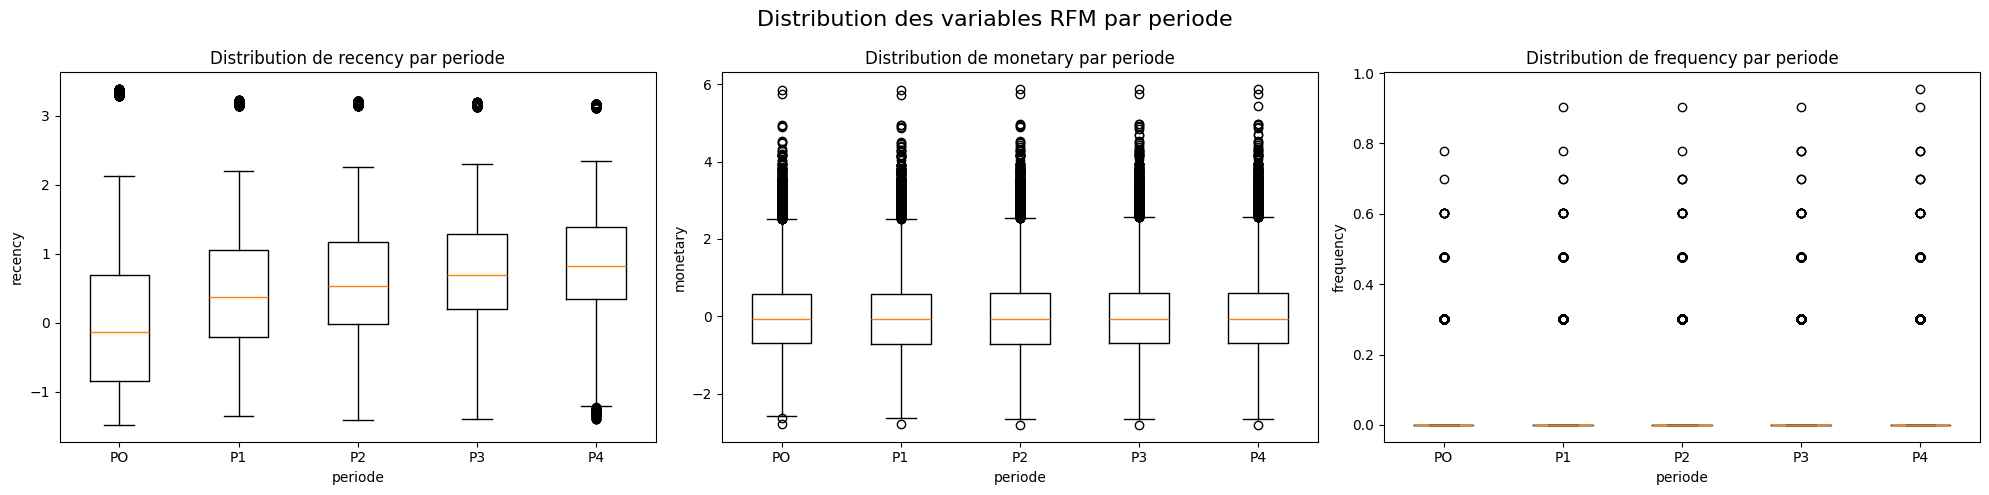

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for ax, var in zip(axes, rfm_feats):
  data_to_plot = []
  labels = []
  for periode in ['PO', 'P1', 'P2', 'P3', 'P4']:
    data_to_plot.append(df_evolution[periode][var])
    labels.append(periode)
  ax.boxplot(data_to_plot, tick_labels=labels)
  ax.set_title(f"Distribution de {var} par periode")
  ax.set_xlabel("periode")
  ax.set_ylabel(var)

plt.suptitle("Distribution des variables RFM par periode", fontsize=16)
plt.tight_layout()
plt.show()

## 5.2 | Test statistque de Kolmogorov-Smirnov

Ici, nous effectuerons un test de Kolmogorov-Smirnov pour l'ensemble de nos features
- Hypothèse 0: les deux distributions sont identiques
- Hypothèse 1: il existe une différence significative entre les deux distributions.

In [ ]:
rfm_p3 = df_evolution['P3']

# Test KS sur les variables rfm
for feature in rfm_feats:
  ks_stat, p_value = ks_2samp(rfm_ref.loc[rfm_ref.customer_unique_id.isin(rfm_p3.customer_unique_id), feature], rfm_p3[feature])
  print(f"Test KS pour {feature} entre le modèle de référence et la période {(ref_date + pd.DateOffset(months=2)).strftime('%Y-%m')}:")
  print(f"Statistique KS = {ks_stat:.3f}, p-value = {p_value:.3f}")
  if p_value < 0.05:
    print("L'hypothèse nulle est rejetée, il existe une différence significative entre les distributions.")
  else:
    print("L'hypothèse nulle est acceptée, il n'y a pas de différence significative entre les distributions.")
  print("---"*9)

Test KS pour recency entre le modèle de référence et la période 2017-12:
Statistique KS = 0.452, p-value = 0.000
L'hypothèse nulle est rejetée, il existe une différence significative entre les distributions.
---------------------------
Test KS pour monetary entre le modèle de référence et la période 2017-12:
Statistique KS = 0.008, p-value = 0.391
L'hypothèse nulle est acceptée, il n'y a pas de différence significative entre les distributions.
---------------------------
Test KS pour frequency entre le modèle de référence et la période 2017-12:
Statistique KS = 0.011, p-value = 0.079
L'hypothèse nulle est acceptée, il n'y a pas de différence significative entre les distributions.
---------------------------


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Création des données
data = {
    "Mesure": ["Recency", "Monetary", "Frequency"],
    "Statistique KS": [0.452, 0.008, 0.011],
    "p-value": [0.000, 0.391, 0.079],
    "Conclusion": [
        "Hypothèse nulle rejetée",
        "Hypothèse nulle acceptée",
        "Hypothèse nulle acceptée"
    ]
}

df = pd.DataFrame(data)

# Création de la figure et désactivation des axes
fig, ax = plt.subplots(figsize=(12, 2))
ax.axis('off')

# Création du tableau
table = ax.table(cellText=df.values,
                 colLabels=df.columns,
                 loc='center',
                 cellLoc='left')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
plt.title('Test statistque de Kolmogorov-Smirnov', fontdict={'color': '#1f3374', 'fontsize': 14, 'fontweight': 'bold'})
# Sauvegarde de l'image
plt.savefig('dataframe_table.png', bbox_inches='tight', dpi=300)
plt.show()


- Recency et monetary ayant significativement évolué, le modèle de clustering initial (basé sur la distribution de référence) pourrait ne plus refléter parfaitement la réalité de décembre 2017.
- La frequency restant stable, il se peut que les clients achètent autant de fois, mais à des intervalles différents ou avec des montants différents.

# 6 | Recommendation

Au vu de la forte chute de l’ARI dès le deuxième mois et des changements significatifs observés dans la distribution de certaines variables (notamment *recency*), il apparaît qu’un réentraînement du modèle de clustering tous les **trois mois** est judicieux. Cette fréquence de mise à jour permet de conserver une segmentation pertinente, en phase avec l’évolution rapide du comportement client, tout en évitant un recalcul trop fréquent et coûteux. Ainsi, nous pourrons maintenir une vision fiable des groupes de clients et agir en conséquence (campagnes marketing, relances ciblées, etc.) en s'assurant que la structure des clusters reflète toujours la réalité la plus récente.

In [ ]:
t_final = time.time()
print(f"La durée d'execution compléte du notebook est de: {t_final - t_init} secondes")

La durée d'execution compléte du notebook est de: 320.6747934818268 secondes


# FIN